In [1]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import IPython.display as ipyd
from PIL import Image
from tqdm import tqdm

In [2]:
n_slices = 155
label_color_map = {0: [0,0,0], 63: [0,0,255], 127: [0,255,0], 255: [255,0,0]}
modes = ['flair', 't1', 't1ce', 't2']

In [5]:
def load_nifti(img_path):
    """
    Loads data from nifti file into 3D numpy array
    """
    img = nib.load(img_path)
    img = img.get_fdata()
    img = (img/img.max())*255
    img = img.astype(np.uint8)
    return img


def generate_img_slices(img_path, target_path, resize=None):
    """
    Generates 2D image slices from 3D nifti image files and saves them in the target folder
    """
    img_name = os.path.split(img_path)[-1].split('.')[0]
    img = load_nifti(img_path)
    
    # Generate slices
    for i in range(img.shape[2]):
        img_slice_name = img_name + '_' + str(i) + '.jpg'
        img_slice_path = os.path.join(target_path, img_slice_name)
        img_slice = img[:,:,i]
        
        if resize:
            img_slice = cv2.resize(img_slice, dsize=(resize,resize), interpolation=cv2.INTER_CUBIC)
       
        # Make output directory if not exists
        try: os.makedirs(target_path)
        except FileExistsError: pass
        cv2.imwrite(img_slice_path, img_slice)
        
        
def generate_seg_slices(seg_path, target_path):
    """
    Generates 2D segmentation mask slices from 3D nifti segmentation mask files and saves them in the target folder
    """
    seg_name = os.path.split(seg_path)[-1].split('.')[0]
    seg = load_nifti(seg_path)
    
    # Generate slices
    for i in range(seg.shape[2]):
        seg_slice_name = seg_name + '_' + str(i) + '.npy'
        seg_slice_path = os.path.join(target_path, seg_slice_name)
        seg_slice = seg[:,:,i]
        
        # Make output directory if not exists
        try: os.makedirs(target_path)
        except FileExistsError: pass
        np.save(seg_slice_path, seg_slice)
    
    
def apply_seg_mask(img_arr, seg_arr):
    """
    Receives numpy arrays of a 2D RGB image and a 2D RGB segmentation mask slice and applies the latter on the former, producing a numpy array of a segmented image.
    """
    seg_img_arr = img_arr.copy()
    mask = np.any(seg_arr!=[0,0,0],axis=2)  #  Select the pixels of the segmentation mask where the mask is not empty (axis 2 is for the color channel)
    seg_img_arr[mask] = seg_arr[mask]  # Apply the non-empty pixels of the segmentation mask to the image
    return seg_img_arr

    
def plot_gif(data_path, id, save_path):
    """
    Plots gif for each modality from a data sample id
    """
    frames = {mode: [] for mode in modes}
    
    for n in range(n_slices): # For each slice
        
        # Load segmentation mask slice
        seg_name = f'BraTS20_Training_{"0" * max(0, 3 - len(str(id))) + str(id)}_seg'
        seg_slice_path = os.path.join(data_path, seg_name + f'_{n}.npy')
        seg_slice =  np.load(seg_slice_path)
        
        # Convert segmentation mask slice to RGB numpy array using a label-color mapping
        seg_slice_rgb = np.zeros([dim for dim in list(seg_slice.shape)] + [3])  # Add extra dimension (3) for RGB
        for label in label_color_map.keys():
            seg_slice_rgb[seg_slice==label] = label_color_map[label]
            
        # TODO: Might need to resize the segmentation mask  array to match the image array in case we resized the images

        # Plot gif for each modality of slice n
        for mode in modes:
            
            # Load image slice
            img_name = f'BraTS20_Training_{"0" * max(0, 3 - len(str(id))) + str(id)}_{mode}'  
            img_slice_path = os.path.join(data_path, img_name + f'_{n}.jpg')
            img_slice = Image.open(img_slice_path)
             
             # Convert image slice to RGB numpy array
            img_slice_rgb = np.expand_dims(np.asarray(img_slice),axis=2).repeat(3,axis=2)
            
            seg_img_slice = Image.fromarray(apply_seg_mask(img_slice_rgb, seg_slice_rgb))  # Generate a segmented image slice
            frames[mode].append(seg_img_slice)  # Add it as a frame to the gif
        
    for mode in modes:  
        img_name = f'BraTS20_Training_{"0" * max(0, 3 - len(str(id))) + str(id)}_{mode}' 
        gif_path = os.path.join(save_path, img_name + '.gif')
        frame_one = frames[mode][0]
        frame_one.save(gif_path, format="GIF", append_images=frames[mode],
                   save_all=True, duration=100, loop=0)
        print(f'Saved at: {gif_path}')
        
        
def generate_2D_dataset(source_path, target_path, resize=None):
    """
    Generates 2D dataset in target path from the 3D dataset in source path
    """
    for sample_name in tqdm(next(os.walk(source_path))[1]):  # For every folder (dataset sample) in the source path
        sample_path = os.path.join(source_path, sample_name)
        for file_name in next(os.walk(sample_path))[2]:  # For every file in the sample path
            file_path = os.path.join(sample_path,file_name)
            if 'seg' not in file_name:  # If the file is a modality and not a segmentation mask
                generate_img_slices(file_path, target_path, resize)
            else:
                generate_seg_slices(file_path, target_path)
            

In [16]:
generate_2D_dataset('/mnt/5C5C25FB5C25D116/data/BraTS2020/train', '/mnt/5C5C25FB5C25D116/data/BraTS2020/train_2D')

100%|██████████| 369/369 [04:17<00:00,  1.43it/s]


In [17]:
generate_2D_dataset('/mnt/5C5C25FB5C25D116/data/BraTS2020/val', '/mnt/5C5C25FB5C25D116/data/BraTS2020/val_2D')

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


In [55]:
plot_gif('/mnt/5C5C25FB5C25D116/data/BraTS2020/train_2D', 26, '../results')

Saved at: ../results/BraTS20_Training_026_flair.gif
Saved at: ../results/BraTS20_Training_026_t1.gif
Saved at: ../results/BraTS20_Training_026_t1ce.gif
Saved at: ../results/BraTS20_Training_026_t2.gif


In [1]:
import numpy as np
from glob import glob
import SimpleITK as sitk
from tqdm import tqdm
import os

def load_sitk_with_resample(img_path):
    outsize = [0, 0, 0]
    outspacing = [1, 1, 1]

    vol = sitk.ReadImage(img_path)
    inputsize = vol.GetSize()
    return inputsize

data_path = '/projects/0/prjs0905/data/LiTS17/train/ct'
xyz = []

luna_subset_path = os.path.join(data_path)
file_list = glob(os.path.join(luna_subset_path, "*.nii"))  # Only selects .nii files (excludes the segmentations)

for img_file in tqdm(file_list):
    img_name = os.path.split(img_file)[-1]
    size = load_sitk_with_resample(img_file)
    xyz.append(size[2])
        

100%|██████████| 111/111 [01:34<00:00,  1.17it/s]


In [2]:
print(np.max(xyz))
print(np.min(xyz))

987
75


In [95]:
source_path = '/projects/0/prjs0905/data/LUNA16/subset0'
imgs = []
segs = []
for file_name in tqdm(next(os.walk(source_path))[2]):  # For every folder (dataset sample) in the source path
    file_path = os.path.join(source_path, file_name)
    if 'mhd' in file_name:
        
    imgs.append(file_path)  

print(imgs)


100%|██████████| 178/178 [00:00<00:00, 325593.59it/s]

['/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.raw', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.raw', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.mhd', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw', '/projects/0/prjs0905/data/LUNA16/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.1377632127521540819

In [5]:
img_idx = 20
s_idx = 50
img_path = imgs[20]
img_name = os.path.split(img_path)[-1].split('.')[0]

img = {}
for mode in modes:
    img[mode] = load_nifti(os.path.join(img_path,f'{img_name}_{mode}.nii.gz'))[:,:,s_idx]
seg = load_nifti(os.path.join(img_path,f'{img_name}_seg.nii.gz'))[:,:,s_idx]

for mode in modes:
    plt.imshow(img[mode][:,:], cmap='grey')
    plt.axis('off')
    plt.show()
    /projects/0/prjs0905/data/LUNA16/subset0
plt.imshow(seg[:,:])
plt.axis('off')
plt.show()



NameError: name 'imgs' is not defined

In [46]:
img_idx = 26
img_path = f'/projects/0/prjs0905/data/LiTS17/train/ct/volume-{img_idx}.nii'
seg_path = f'/projects/0/prjs0905/data/LiTS17/train/seg/segmentation-{img_idx}.nii'

In [48]:
import SimpleITK as sitk

s_idx = 370
img_name = os.path.split(img_path)[-1].split('.')[0]

img = sitk.ReadImage(img_path, sitk.sitkInt16)
seg = sitk.ReadImage(seg_path, sitk.sitkUInt8)

img = sitk.GetArrayFromImage(img)[s_idx,:,:]
seg = sitk.GetArrayFromImage(seg)[s_idx,:,:]

img[img>1000] = 1000
img[img<-1000] = -1000

img = (img + 1000) / 2000

start_x = 20
start_y = 45
step = 410
img = img[::-1,::-1][start_x:start_x+step,start_y:start_y+step]
seg = seg[::-1,::-1][start_x:start_x+step,start_y:start_y+step]


# plt.imshow(img, cmap='grey')
# plt.axis('off')
# plt.show()
    
# plt.imshow(seg)
# plt.axis('off')
# plt.show()

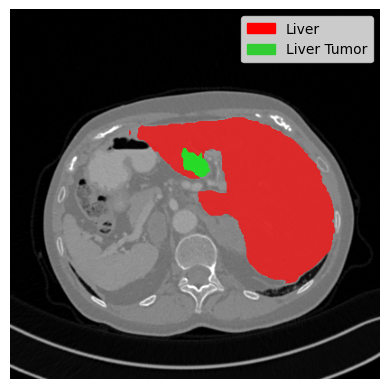

In [50]:
import matplotlib.patches as mpatches

img_new =  np.expand_dims(img,2).repeat(3, axis=2).astype(np.float32)
seg1 = np.where(seg == 1, 1, 0)
seg2 = np.where(seg == 2, 1, 0)
seg_new1 = np.stack([seg1, np.zeros(seg1.shape), np.zeros(seg1.shape)],axis=2).astype(np.float32)
seg_new2 = np.stack([np.zeros(seg2.shape), seg2, np.zeros(seg2.shape)],axis=2).astype(np.float32)


# Apply segmentation mask on image
alpha = 1 - img_new
mask = np.expand_dims((np.sum(seg_new1,axis=2)!=0),2).repeat(3, axis=2)
blend = cv2.addWeighted(img_new, 0.3, seg_new1, 0.7, 0)  # Add trasnparency to seg. mask
mask_img = np.where(mask!=[0,0,0], blend, img_new)  # Apply seg. mask

mask = np.expand_dims((np.sum(seg_new2,axis=2)!=0),2).repeat(3, axis=2)
blend = cv2.addWeighted(img_new, 0.3, seg_new2, 0.7, 0)  # Add trasnparency to seg. mask
mask_img = np.where(mask!=[0,0,0], blend, mask_img)  # Apply seg. mask

plt.imshow(mask_img)
plt.axis('off')
liver_seg = mpatches.Patch(color='red', label='Liver')
tumor_seg = mpatches.Patch(color='limegreen', label='Liver Tumor')
plt.legend(handles=[liver_seg,tumor_seg])
plt.show()


In [75]:
print(img.shape)
print(seg_new.shape)


(512, 512, 3, 3, 3, 3)
(512, 512, 3)


In [56]:
np.sum(seg2)

16682

In [50]:
np.any(seg==2,axis=2)

AxisError: axis 2 is out of bounds for array of dimension 2

In [51]:
seg.shape

(410, 410)